<h1><center>Building an Anomaly detection system using Elasticsearch and Apache Spark</center></h1>

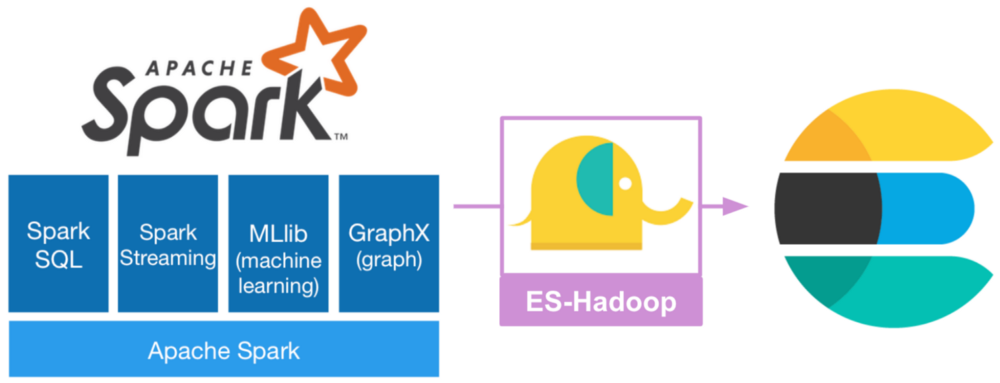

<h1>Anomaly Detection in Logs</h1>

<span style="text-align: center;">La détection d'anomalies/de valeurs aberrantes a pris de l'ampleur ces derniers jours, en raison de ses applications en matière de cybersécurité et de surveillance des serveurs. Ce dépôt explore comment utiliser les vecteurs de comptage et identifier les anomalies par un apprentissage supervisé/non supervisé.</span>

<h2>À propos du jeu de données</h2>

Le jeu de données est un journal de données d'un serveur distant généré sur 15 jours. Ce jeu de données est recupéré directement à partir des logs nginx préconfigurés sur lesquels nous souhaitons identifier des anomalies.

Colonnes:
<ul>
    <li>Timestamp of the log</li>
    <li>User IP from which the request is made</li>
    <li>Method</li>
    <li>Request path</li>
    <li>Status</li>
    <li>Request time</li>
    <li>Upstream status</li>
    <li>Upstream response time</li>
    <li>Upstream connect time</li>
    <li>Upstream header time</li>
</ul>

<h2>Approche</h2>

Nous utilisons les profils pour l'IP de l'utilisateur sur certaines périodes de temps. Cette période peut varier de quelques heures à quelques semaines. Le profil peut inclure des vecteurs de comptage de base tels que les comptages totaux, les comptages unitaires moyens (jour/semaine/heure) jusqu'à des vecteurs d'appels réseau complexes tels que le ratio de chargement/téléchargement en fonction du cas d'utilisation.

Dans ce répertoire, nous utilisons des vecteurs de comptage et de fréquence de base. Avec les profils en main, nous pouvons utiliser des algorithmes ML pour identifier les anomalies.

<h2>Approche ML</h2>

Une fois que l'espace de caractéristiques est généré, nous utilisons les kmeans pour faire des clusters et les points qui sont plus éloignés de tous les clusters combinés sont considérés comme anormaux. Nous utilisons la somme des distances au carré des centroïdes dans cette version. Nous utilisons la distance au carré au lieu de la distance absolue pour pondérer les points aberrants plus que les autres (similaire à l'utilisation de MAE vs MSE).

Si la distance euclidienne dans l'espace des caractéristiques est une façon de voir les choses, l'arbre d'isolation offre une approche unique de ce problème. Les arbres d'isolation considèrent le nombre de divisions nécessaires pour atteindre un certain point. Moins il faut de divisions, plus le point est isolé et donc anormal.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import re
import geoip2.database
from datetime import datetime
import time
import os

In [2]:
LOG_FORMAT = 'App $pid output: [$time] [$type[39m ($pid_info): '+'[36m$log[39m'

In [3]:
REGEX_LOG_FORMAT_VARIABLE = r'\$([a-zA-Z0-9\_]+)'
REGEX_SPECIAL_CHARS = r'([\.\*\+\?\|\(\)\{\}\[\]])'

In [4]:
def build_pattern(log_format):
    pattern = re.sub(REGEX_SPECIAL_CHARS, r'\\\1', log_format)
    pattern = re.sub(REGEX_LOG_FORMAT_VARIABLE, '(?P<\\1>.*)', pattern)
    return re.compile(pattern)

partent = build_pattern(LOG_FORMAT)

In [7]:
def load_data():
    with open('./dataset/error_data.log', 'r') as file:
        for count, line in enumerate(file):
            line = line.strip()
            if line:
                match = partent.match(line)
                if match != None: 
                    # to do when data ingestion
                    item = match.groupdict()
                    del item['pid_info']
                    yield item

In [29]:
items = list(load_data())
len(items)

59266

In [30]:
import pandas as pd
df = pd.DataFrame(items)
df.head()

,pid,time,type,log
0,4293,1648655592284,32mINFO,signin.controller +221782908626
1,4293,1648655592285,32mINFO,--INIT LOGIN---
2,4293,1648655592396,32mINFO,signin.controller +221782908626----SUCCESS
3,4293,1648656701339,32mINFO,TEST HEADERS =======>
4,4293,1648656701339,32mINFO,INIT HEADERS


<h2>Preprocessing</h2>

In [31]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

<h3>A. Remove special characters, numbers, punctuations</h3>

In [32]:
# remove special characters, numbers, punctuations
df['tidy_log'] = df['log'].str.replace("[^a-zA-Z#]", " ")
df['tidy_log'].head()

0               signin controller              
1                                 INIT LOGIN   
2    signin controller                  SUCCESS
3                         TEST HEADERS         
4                                  INIT HEADERS
Name: tidy_log, dtype: object

<h3>B. Removing Short Words</h3>

In [33]:
# remove words that having length 3 or less
df['tidy_log'] = df['tidy_log'].apply(lambda x: ' '.join([w for w in x.split() if len(w) >= 3]))
df.head()

,pid,time,type,log,tidy_log
0,4293,1648655592284,32mINFO,signin.controller +221782908626,signin controller
1,4293,1648655592285,32mINFO,--INIT LOGIN---,INIT LOGIN
2,4293,1648655592396,32mINFO,signin.controller +221782908626----SUCCESS,signin controller SUCCESS
3,4293,1648656701339,32mINFO,TEST HEADERS =======>,TEST HEADERS
4,4293,1648656701339,32mINFO,INIT HEADERS,INIT HEADERS


<h3>C. Labeling</h3>

In [34]:
df['label'] = np.select((df['type'].str.contains("INFO", case=False),
                         df['type'].str.contains("ERROR", case=False)), (0, 1), np.nan)  
df.loc[df['label']==1].head()

,pid,time,type,log,tidy_log,label
236,4293,1648719647030,31mERROR,SMS failed due to : Request failed with status...,SMS failed due Request failed with status code,1.0
291,4293,1648723773329,31mERROR,SMS failed due to : Request failed with status...,SMS failed due Request failed with status code,1.0
702,4293,1648743947457,31mERROR,SMS failed due to : Request failed with status...,SMS failed due Request failed with status code,1.0
1343,4293,1649100493487,31mERROR,BALANCE WIZALL UNAVALAIBLE ------------ RESPONSE,BALANCE WIZALL UNAVALAIBLE RESPONSE,1.0
1375,4293,1649103661888,31mERROR,BALANCE WIZALL UNAVALAIBLE ------------ RESPONSE,BALANCE WIZALL UNAVALAIBLE RESPONSE,1.0


In [45]:
final_data = df.loc[df['label']==1]
final_data = final_data.groupby(['tidy_log']) \
       .agg(log_count=('tidy_log', 'size')).reset_index()
final_data.head()

,tidy_log,log_count
0,AirtimeTransaction controller WIZALL ERROR,22
1,BALANCE WIZALL UNAVALAIBLE RESPONSE,446
2,CANNOT GET CURRENT BALANCE WIZALL REQUEST FAILED,20
3,GET TOKEN FROM NANO FAILED,28
4,HANDLEERROR statusCode error message error Auc...,44


<h2>Feature Building</h2>

<b>To do later</b>

<h2>Story Generation and Visulisation from Tweets</h2>

In this section, we will explore the cleaned tweets text. Exoploring and visualizing data, no matter whether its text or any other data, is an important step in gaining insights.<br>
Before we begin exploration, we must think and ask questions related to the data in hand. A few probable questions are as follow:
<ul>
    <li>What are the most common words in the entire dataset?</li>
    <li>What are the most common words in the dataset for negative and positive tweets, respectively?</li>
    <li>How many hastags are there in a tweet?</li>
    <li>Which trends are associated with my dataset?</li>
    <li>Which trends are associated with either of the sentiments? Are they compatible with the sentiments?</li>
</ul>

<h3>A. Understanding the common words used in the logs</h3>

Now We want to see how well the given sentiments are distributed across the train dataset. One way to accomplish this task is understanding the common words by plotting <span style='color: blue'>wordclouds</span>.<br>
A wordcloud is a visualiztion wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.<br>
Let's visualize all the words our data using the wordcloud plot.

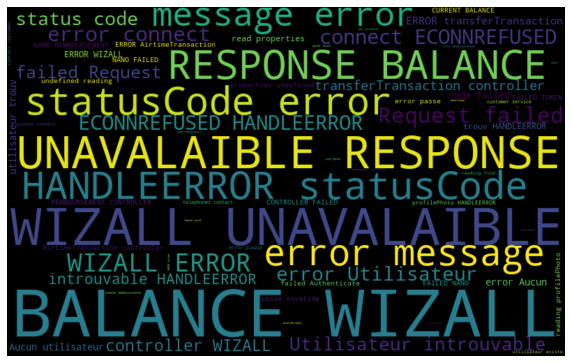

In [18]:
from wordcloud import WordCloud
all_words = ' '.join([text for text in final_df['tidy_log']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

As we can cleary see, most of the words have negative or neutral connotations. So, it seems we have a pretty good text data to work on. Next we will do the hashtags/trends in our log data.

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [46]:
RANDOM_STATE = 123

<h2>Isolated Forests</h2>

In [55]:
outlier_fraction = 0.028

In [47]:
final_data.columns

Index(['tidy_log', 'log_count'], dtype='object')

In [50]:
min_max_scaler = preprocessing.MinMaxScaler()

In [52]:
data_new = final_data[['log_count']]
np_scaled = min_max_scaler.fit_transform(data_new)
data_new = pd.DataFrame(np_scaled, columns=['log_count'])

In [53]:
data_new.fillna(0,inplace=True)
data_new.head()

,log_count
0,0.047191
1,1.000000
2,0.042697
3,0.060674
4,0.096629


In [58]:
model =  IsolationForest(n_jobs=-1, n_estimators=200, max_features=1, random_state=RANDOM_STATE, contamination=outlier_fraction)

In [59]:
model.fit(data_new)

IsolationForest(contamination=0.028, max_features=1, n_estimators=200,
                n_jobs=-1, random_state=123)

In [60]:
# add the data to the main  
final_data['anomaly_isolated'] = pd.Series(model.predict(data_new))

In [61]:
final_data['anomaly_isolated'] = final_data['anomaly_isolated'].map( {1: 0, -1: 1} )

In [62]:
final_data['anomaly_isolated'].value_counts()

0    27
1     1
Name: anomaly_isolated, dtype: int64

In [63]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=RANDOM_STATE)

In [64]:
tsne_results = tsne.fit_transform(data_new)

[t-SNE] Computing 27 nearest neighbors...
[t-SNE] Indexed 28 samples in 0.001s...
[t-SNE] Computed neighbors for 28 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 28 / 28
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.923737
[t-SNE] KL divergence after 300 iterations: 0.509471


In [65]:
final_data['tsne-2d-one'] = tsne_results[:,0]
final_data['tsne-2d-two'] = tsne_results[:,1]

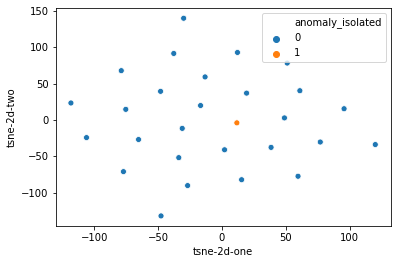

In [66]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="anomaly_isolated",
#     palette=sns.color_palette("hls", 10),
    data=final_data,
    legend="full",
    alpha=1
)

In [67]:
final_data.loc[final_data['anomaly_isolated']==1]

,tidy_log,log_count,anomaly_isolated,tsne-2d-one,tsne-2d-two
1,BALANCE WIZALL UNAVALAIBLE RESPONSE,446,1,11.608492,-3.788938


<h2>Performance of Algo</h2>

Since it is unsupervised we need to manually label the data and see the performance of the individual algos

<ul>
    <li>Criteria for manual labels is strictly based on counts as we want the algos to be robust on count anomalies</li>
</ul>

In [69]:
total_counts_condition = (final_data['log_count'] >= final_data['log_count'].quantile(0.98)) 

In [70]:
final_data['anomaly_manual'] = (total_counts_condition).astype(np.int)

In [71]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix

In [72]:
def get_sensitivity_specificity(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    sensitivity = cf[0,0]/(cf[:,0].sum())
    specificity = cf[1,1]/(cf[:,1].sum())
    return sensitivity, specificity

In [73]:
f1_iso = f1_score(final_data['anomaly_manual'],final_data['anomaly_isolated'])
acc_iso = accuracy_score(final_data['anomaly_manual'],final_data['anomaly_isolated'])
roc_iso = roc_auc_score(final_data['anomaly_manual'],final_data['anomaly_isolated'])
sen_iso, spec_iso = get_sensitivity_specificity(final_data['anomaly_manual'],final_data['anomaly_isolated'])
met_iso = {
           'f1_score': f1_iso,
           'accuracy': acc_iso,
           'roc_score': roc_iso,
           'sensitivity': sen_iso,
           'specificity': spec_iso
          }

In [ ]:
f1_svm = f1_score(final_data['anomaly_manual'],final_data['anomaly_svm'])
acc_svm = accuracy_score(final_data['anomaly_manual'],final_data['anomaly_svm'])
roc_svm = roc_auc_score(final_data['anomaly_manual'],final_data['anomaly_svm'])
sen_svm, spec_svm = get_sensitivity_specificity(final_data['anomaly_manual'],final_data['anomaly_svm'])
met_svm = {
           'f1_score': f1_svm,
           'accuracy': acc_svm,
           'roc_score': roc_svm,
           'sensitivity': sen_svm,
           'specificity': spec_svm
          }

In [74]:
metrics = {'isolated_forest': met_iso,
#            'svm': met_svm
          }

In [75]:
metrics_df = pd.DataFrame.from_dict(metrics)

In [76]:
metrics_df

,isolated_forest
accuracy,1.0
f1_score,1.0
roc_score,1.0
sensitivity,1.0
specificity,1.0
